## Feature Selection Exercise
Peyton needs your help optimizing her campaign.  She wants to get more conversions and doesn't know which data features will help.  She has some campaign data she wants you to analyze.  In the campaign data file, you will find the following fields:

Hour of day
Segments
Device
Result (1=Conversion, 0=No Conversion)

Using Python and scikit-learn, identify the most predictive feature(s) for the result.  Please submit a zipped python file and a short explanation of your findings. 

### Data Exploration
This data does not have any null values and is relatively clean. There are three features (hour, segments, device) and a target column ('result'). There's an almost equal split between 'Conversion' and 'No Conversion' results, making this data set well balanced. 

There is one column containing string values (device) that needs to be converted to integers before we implement feature selection techniques.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

In [2]:
campaign_data = pd.read_csv('campaign_data.csv')

In [3]:
campaign_data.head()

,hour,segments,device,result
0,9,51,Smartphone,1
1,9,51,Tablet,1
2,9,91,Smartphone,1
3,9,331,Desktop,1
4,9,41,Smartphone,1


In [4]:
campaign_data.shape

(3312, 4)

In [5]:
campaign_data.isnull().values.any()

False

In [9]:
campaign_data['device'].value_counts()

Smartphone    1403
Tablet        1098
Desktop        811
Name: device, dtype: int64

In [6]:
campaign_data['result'].value_counts()

1    1658
0    1654
Name: result, dtype: int64

### Data Preparation and Visualization
To be able to use the data, we map the string values of the device columns into integer values using sklearn's LabelEncoder. From there, we draw visualizations to better understand the relationship of the features to the target.

We can see that there are opportunities to optimize which hours we choose to target our customers (conversion is highest around the hours 10-12, with hour 10 being particularly relevant). We also see that tablet devices have the highest correlations with conversion, while desktops have the lowest correlation with conversion. 

In [16]:
df = campaign_data
le = preprocessing.LabelEncoder()
le.fit(df['device'])
df['device_int'] = le.transform(df['device'])
df = df[['hour', 'segments', 'device', 'device_int', 'result']]
print(df['device_int'].isnull().any())
print(dict(zip(df['device'], df['device_int'])))

False
{'Smartphone': 1, 'Tablet': 2, 'Desktop': 0}


In [17]:
df.head()

,hour,segments,device,device_int,result
0,9,51,Smartphone,1,1
1,9,51,Tablet,2,1
2,9,91,Smartphone,1,1
3,9,331,Desktop,0,1
4,9,41,Smartphone,1,1


Text(0.5,0,'Hour')

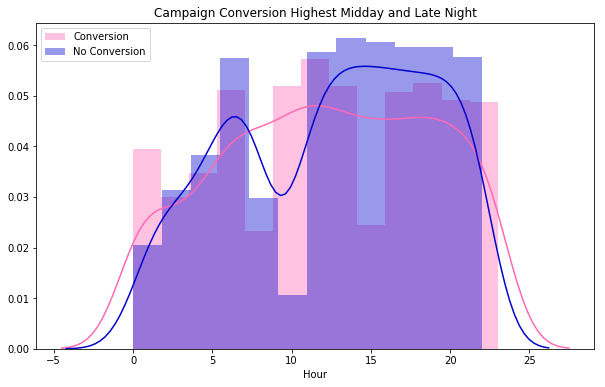

In [20]:
def distplot(feature):
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    sns.distplot(df[feature][df['result']==1] ,color='hotpink', ax=ax)
    sns.distplot(df[feature][df['result']==0] ,color='mediumblue', ax=ax )
    plt.legend(['Conversion', 'No Conversion'])

distplot('hour')
plt.title('Campaign Conversion Highest Midday and Late Night')
plt.xlabel('Hour')

Text(0.5,0,'Device')

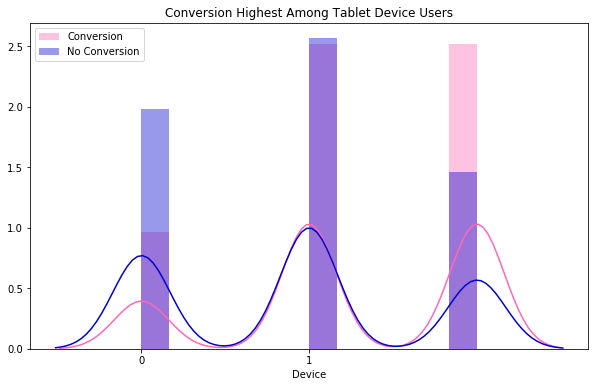

In [21]:
distplot('device_int')
plt.xticks(np.arange(0, 2, 1))
plt.title('Conversion Highest Among Tablet Device Users')
plt.xlabel('Device')

### Feature Selection

In [22]:
df_features = df[['hour', 'segments', 'device_int']]
df_target = df['result']
df_features.head()

,hour,segments,device_int
0,9,51,1
1,9,51,2
2,9,91,1
3,9,331,0
4,9,41,1


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size= 0.3, random_state=42)

#### Random Forest Classifier
The feature importance of the Random Forest Classifier tells us that the best features for predicting conversion are: hour, segments, device.

Feature ranking:
1. feature 0 (0.516753)
2. feature 1 (0.383461)
3. feature 2 (0.099786)


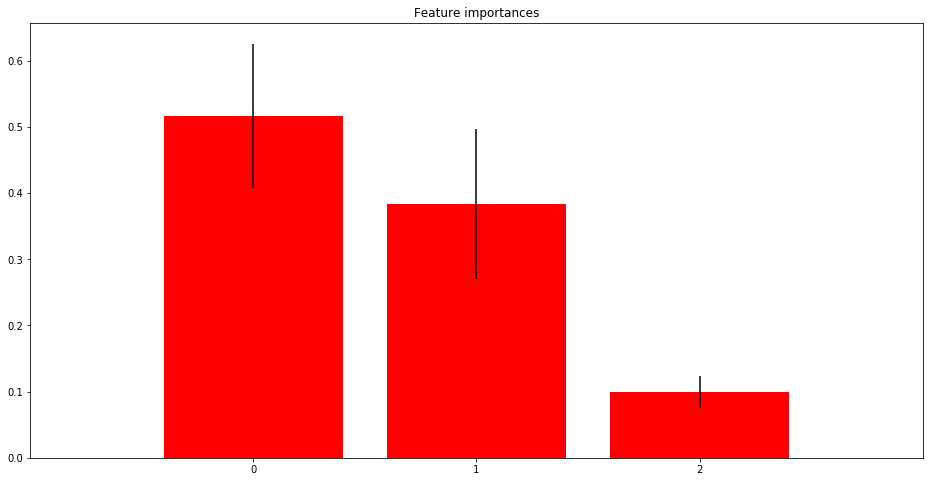

In [24]:
forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### Extra Trees Classifier
The Extra Trees Classifier shows us that the feature importances are the same as the Random Forest Classifier's rankings, with the device feature being slightly stronger in Extra Trees than in Random Forest.

In [26]:
X = df_features.values
Y = df_target.values

In [27]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)

[ 0.44565966  0.34218851  0.21215183]


#### XGB Classifier
The XGB Classifier agrees with the Random Forest Classifier and Extra Trees Classifer, but gives device more importance relative to the importance this feature is given by the other two. Hour and segments are still the strongest performing feature.

The feature importance module shows us that accuracy is highest when we have two features selected, and accuracy of the model decreases when we have three features in the model.

sorted_idx = np.argsort(model.feature_importances_)[::-1]
X_train = pd.DataFrame(X_train)
for index in sorted_idx:
    print([X_train.columns[index], model.feature_importances_[index]]) 
plot_importance(model, max_num_features = 15)
pyplot.show()

In [38]:
# fit model on all training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 60.66%
Thresh=0.088, n=3, Accuracy: 60.66%
Thresh=0.292, n=2, Accuracy: 61.67%
Thresh=0.620, n=1, Accuracy: 58.10%


#### Other Methods

In [43]:
# feature extraction
test = SelectKBest(score_func=f_classif, k=3)
fit = test.fit(X, Y)
# summarize scores
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

[  3.31388941e+00   1.33875229e-01   1.83592670e+02]
[[  9  51   1]
 [  9  51   2]
 [  9  91   1]
 [  9 331   0]
 [  9  41   1]]


In [47]:
chi2_score, chi_2_p_value = chi2(X,y)
f_score, f_p_value = f_classif(X,y)
mut_info_score = mutual_info_classif(X,y)
print('chi2 score        ', chi2_score)
print('chi2 p-value      ', chi_2_p_value)
print('F - score score   ', f_score)
print('F - score p-value ', f_p_value)
print('mutual info       ', mut_info_score)

('chi2 score        ', array([ 10.94545345,   9.00406415,  91.11763652]))
('chi2 p-value      ', array([  9.38335799e-04,   2.69379893e-03,   1.35379641e-21]))
('F - score score   ', array([  3.31388941e+00,   1.33875229e-01,   1.83592670e+02]))
('F - score p-value ', array([  6.87869845e-02,   7.14470809e-01,   9.53006036e-41]))
('mutual info       ', array([ 0.04340457,  0.00115703,  0.02542613]))


In [49]:
rf = RandomForestRegressor()
feat_names = ['hours', 'segments', 'device']
rf.fit(X, Y)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feat_names), 
             reverse=True))

Features sorted by their score:
[(0.4606, 'segments'), (0.4547, 'hours'), (0.0847, 'device')]
